# Análisis de Amazon Reviews

## Carga de librerías necesarias para todo el proyecto/entregable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pysentimiento import create_analyzer
from pysentimiento.preprocessing import preprocess_tweet
import nltk
import regex as re
import string
from nltk.stem import RegexpStemmer
from nltk.corpus import stopwords
import spacy
from textblob import TextBlob
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from yellowbrick.text import umap
from wordcloud import WordCloud
from collections import defaultdict, Counter
import wordtree
from tqdm import tqdm


## Carga de archivo JSON de Amazon Reviews para el segmento de Toys and Games

In [3]:
amazon = pd.read_json('datasets/Toys_and_Games.json', lines=True) # Se incluye el parámetro "lines" para que reconozca el archivo completo y lo carge en un df
amazon.head()

,_id,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,class
0,{'$oid': '5a13282b741a2384e879a620'},A3C9CSW3TJITGT,0005069491,Renee,"[0, 0]",I love these felt nursery rhyme characters and...,4,Charming characters but busy work required,1377561600,"08 27, 2013",Toys_and_Games,1
1,{'$oid': '5a13282b741a2384e879a621'},A31POTIYCKSZ9G,0076561046,So CA Teacher,"[0, 0]",I see no directions for its use. Therefore I h...,3,No directions for use...,1404864000,"07 9, 2014",Toys_and_Games,0
2,{'$oid': '5a13282b741a2384e879a622'},A2GGHHME9B6W4O,0131358936,Dalilah G.,"[0, 0]",This is a great tool for any teacher using the...,5,Great CD-ROM,1382400000,"10 22, 2013",Toys_and_Games,1
3,{'$oid': '5a13282b741a2384e879a61f'},AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5,Puzzles,1388016000,"12 26, 2013",Toys_and_Games,1
4,{'$oid': '5a13282b741a2384e879a623'},A1FSLDH43ORWZP,0133642984,Dayna English,"[0, 0]",Although not as streamlined as the Algebra I m...,5,Algebra II -- presentation materials,1374278400,"07 20, 2013",Toys_and_Games,1


## Preprocesamiento de información

### Limpieza del DataFrame

Se hace una selección de variables para poder manejar la información de una forma más amigable

In [4]:
amazon.rename(columns={'reviewText':'reviews'}, inplace=True)
amazon = amazon.drop(['_id', 'helpful', 'reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'summary'], axis=1)
amazon.head()


,reviews,overall,reviewTime,category,class
0,I love these felt nursery rhyme characters and...,4,"08 27, 2013",Toys_and_Games,1
1,I see no directions for its use. Therefore I h...,3,"07 9, 2014",Toys_and_Games,0
2,This is a great tool for any teacher using the...,5,"10 22, 2013",Toys_and_Games,1
3,"Great product, thank you! Our son loved the pu...",5,"12 26, 2013",Toys_and_Games,1
4,Although not as streamlined as the Algebra I m...,5,"07 20, 2013",Toys_and_Games,1


Se hace una revisión para revisar la longitud de datos, si hay datos con errores y/o vacíos y si hay datos duplicados

In [5]:
print('Total data: ', amazon.reviews.count())
print('Total with errors: ', amazon.reviews.isna().sum())
print('Total empty: ', amazon.reviews.isnull().sum())
print('Total duplicated entries: ', amazon.duplicated().sum())

Total data:  1997140
Total with errors:  0
Total empty:  0
Total duplicated entries:  740


Se eliminan los datos duplicados y se inserta una nueva columna 'ID' para referencia futura

In [6]:
amazon = amazon.drop_duplicates()
print('Total data: ', amazon.reviews.count())
print('Total with errors: ', amazon.reviews.isna().sum())
print('Total empty: ', amazon.reviews.isnull().sum())
print('Total duplicated entries: ', amazon.duplicated().sum())
amazon['ID'] = range(0, len(amazon))

Total data:  1996400
Total with errors:  0
Total empty:  0
Total duplicated entries:  0


### Visualización de frecuencias

Número de caracteres por oración en columna 'reviews'

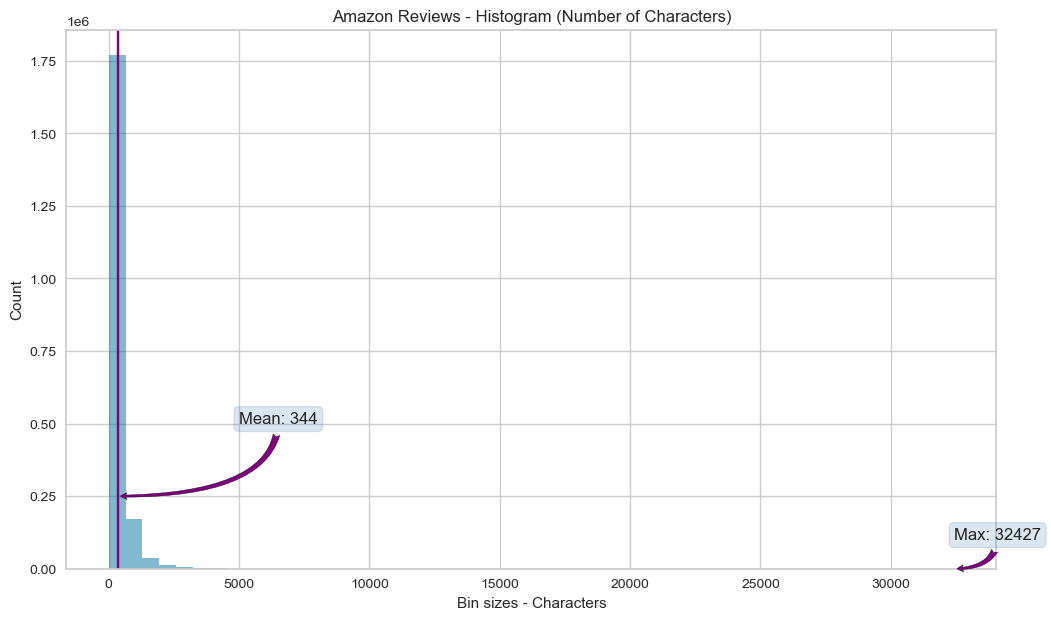

In [7]:
fig, ax = plt.subplots(figsize=(12,7))
ax = amazon['reviews'].str.len().plot.hist(bins=50, alpha=0.5)
plt.axvline(x=amazon['reviews'].str.len().mean(), ymin=0 , ymax=1, color='purple')
text_mean = 'Mean: %d' % amazon['reviews'].str.len().mean()
text_max = 'Max: %d' % amazon['reviews'].str.len().max()
bbox = dict(boxstyle='Round', color='steelblue', alpha=0.2, linewidth=0.9)
arrowprops = dict(facecolor='purple', arrowstyle='fancy', connectionstyle='angle3')
plt.annotate(text=text_mean, xy=(amazon['reviews'].str.len().mean(), 250000), xytext=(5000, 500000), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(amazon['reviews'].str.len().max(), 1), xytext=(amazon['reviews'].str.len().max(), 100000), arrowprops=arrowprops, bbox=bbox)
plt.title('Amazon Reviews - Histogram (Number of Characters)')
plt.xlabel('Bin sizes - Characters')
plt.ylabel('Count')
plt.show()

Se observa que los reviews tienen una media de 344 caracteres y un máximo de 32427

Número de palabras por oración

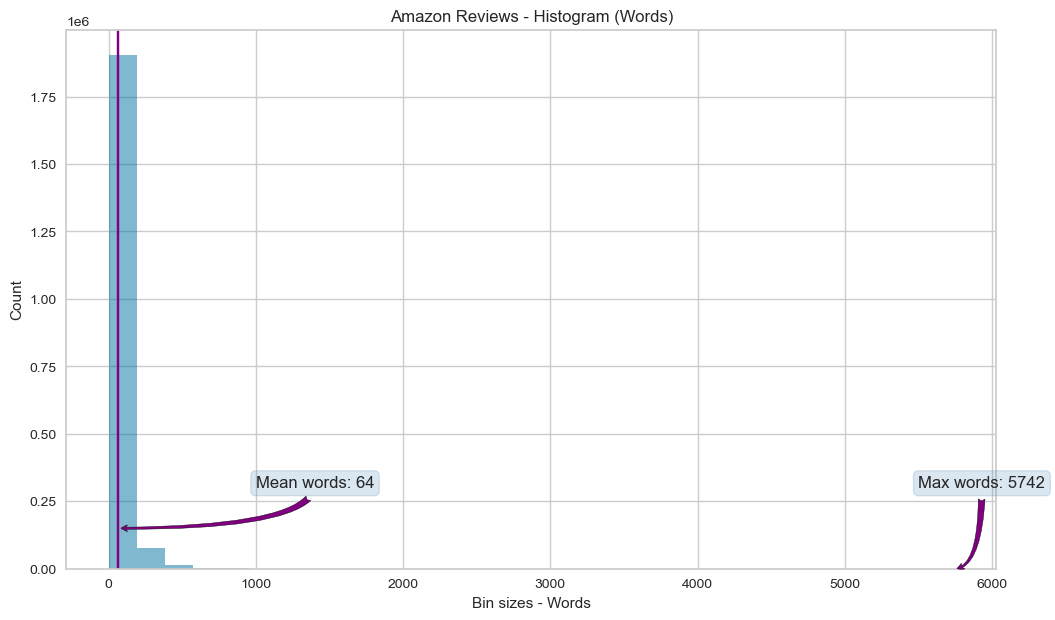

In [8]:
fig, ax = plt.subplots(figsize=(12,7))
ax = amazon['reviews'].str.split().apply(lambda w: len(w)).plot.hist(bins=30, alpha=0.5)
text_mean = 'Mean words: %d' % amazon['reviews'].str.split().apply(lambda w: len(w)).mean()
text_max = 'Max words: %d' % amazon['reviews'].str.split().apply(lambda w: len(w)).max()
plt.axvline(x=amazon['reviews'].str.split().apply(lambda w: len(w)).mean(), ymin=0, ymax=1, color='purple')
plt.annotate(text=text_mean, xy=(amazon['reviews'].str.split().apply(lambda w: len(w)).mean(), 150000), xytext=(1000, 300000), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(amazon['reviews'].str.split().apply(lambda w: len(w)).max(), 1), xytext=(5500, 300000), arrowprops=arrowprops, bbox=bbox)
plt.title('Amazon Reviews - Histogram (Words)')
plt.xlabel('Bin sizes - Words')
plt.ylabel('Count')
plt.show()

Se observa un máximo de 5742 palabras y una media de 64 palabras en los reviews

Se realizará un análisis para determinar el tamaño (longitud) de cada palabra dentro de cada review

In [9]:
a = round(amazon['reviews'].str.split().apply(lambda word: [len(w) for w in word]).map(lambda w: np.mean(w)).mean(), 0)
b = round(amazon['reviews'].str.split().apply(lambda word: [len(w) for w in word]).map(lambda w: np.mean(w)).max(), 0)
print (a, b)

4.0 370.0


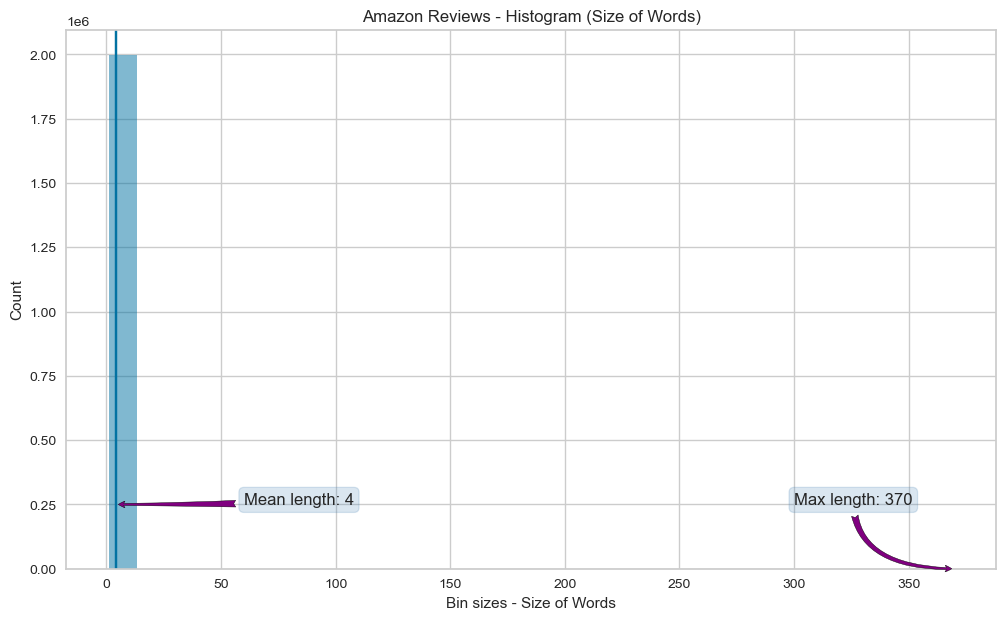

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
ax = amazon['reviews'].str.split().apply(lambda word: [len(w) for w in word]).map(lambda w: np.mean(w)).plot.hist(bins=30, alpha=0.5)
text_mean = 'Mean length: %d' % int(a)
text_max = 'Max length: %d' % int(b)
plt.axvline(x=a, ymin=0, ymax=1)
plt.annotate(text=text_mean, xy=(a, 250000), xytext=(60, 250000), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(b, 1), xytext=(300, 250000), arrowprops=arrowprops, bbox=bbox)
plt.title('Amazon Reviews - Histogram (Size of Words)')
plt.xlabel('Bin sizes - Size of Words')
plt.ylabel('Count')
plt.show()

Se observa una media de 4 caracteres por palabra y un máximo de 370. Posiblemente esta última es un review que no contiene espacios

Se realiza una gráfica de barras para contar el número de reviews por la calificación dada en la columna 'overall'. Esto ayudará a "preveer" si al hacer el análisis de sentimientos se tendrá mayores evaluaciones positivas o negativas

Text(0, 0.5, 'Count of Reviews')

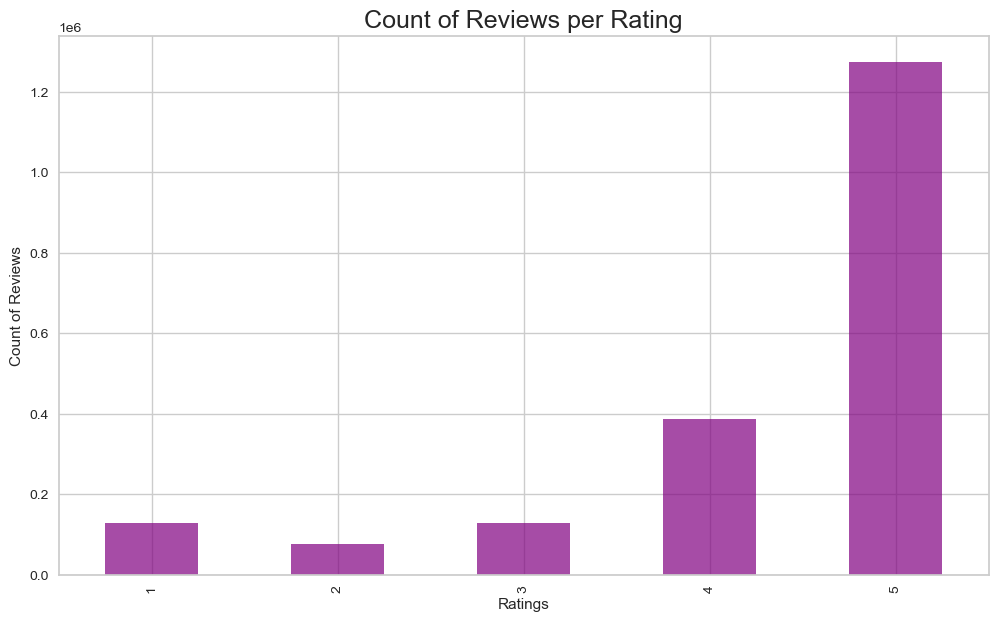

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
ax = amazon['overall'].value_counts().sort_index().plot(kind='bar', color='purple', alpha=0.7)
ax.set_title('Count of Reviews per Rating', fontdict=dict(fontsize=18))
ax.set_xlabel('Ratings')
ax.set_ylabel('Count of Reviews')


Se observa que la mayoría de los comentarios tienden a ser de forma positiva (más de 1,2 millones de reviews con calificación de 5)

Previo a iniciar con el análisis de sentimiento, se revisarán cuantos registros existen en diferentes intervalos de caracteres para decidir si se hace una eliminación de registros

In [12]:
a = len(amazon.where(amazon['reviews'].str.len()>500).dropna())
b = len(amazon.where(amazon['reviews'].str.len()>400).dropna()) - a
c = len(amazon.where(amazon['reviews'].str.len()>300).dropna()) - (a+b)
d = len(amazon.where(amazon['reviews'].str.len()>200).dropna()) - (a+b+c)
e = len(amazon.where(amazon['reviews'].str.len()>100).dropna()) - (a+b+c+d)
f = len(amazon.where(amazon['reviews'].str.len()<100).dropna())



print('Total reviews with less than 100 characters %d' % f)
print('Total reviews with more than 100 characters %d' % e)
print('Total reviews with more than 200 characters %d' % d)
print('Total reviews with more than 300 characters %d' % c)
print('Total reviews with more than 400 characters %d' % b)
print('Total reviews with more than 500 characters %d' % a)


Total reviews with less than 100 characters 86872
Total reviews with more than 100 characters 850726
Total reviews with more than 200 characters 354276
Total reviews with more than 300 characters 211267
Total reviews with more than 400 characters 134521
Total reviews with more than 500 characters 350891


Para facilitiar el procesamiento de los datos, se considerarán solamente los reviews que contengan hasta 150 caracteres.

In [13]:
amazon = amazon.where(amazon['reviews'].str.len()<151).dropna()
amazon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640429 entries, 1 to 1997137
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviews     640429 non-null  object 
 1   overall     640429 non-null  float64
 2   reviewTime  640429 non-null  object 
 3   category    640429 non-null  object 
 4   class       640429 non-null  float64
 5   ID          640429 non-null  float64
dtypes: float64(3), object(3)
memory usage: 34.2+ MB


In [14]:
amazon.head()

,reviews,overall,reviewTime,category,class,ID
1,I see no directions for its use. Therefore I h...,3.0,"07 9, 2014",Toys_and_Games,0.0,1.0
3,"Great product, thank you! Our son loved the pu...",5.0,"12 26, 2013",Toys_and_Games,1.0,3.0
5,i am glad to get it after 25 yr of waiting for...,5.0,"03 18, 2013",Toys_and_Games,1.0,5.0
10,Nephew and Niece loved these! Highly recommend...,5.0,"12 5, 2012",Toys_and_Games,1.0,10.0
12,Great coloring and activity book for young chi...,5.0,"09 25, 2012",Toys_and_Games,1.0,12.0


In [15]:
amazon['reviewTime'] = pd.to_datetime(amazon['reviewTime'])

## Revisión de palabras más frecuentes

Se crea una función para crear un corpus, dentro del cual se incluye la tokenización del texto, la limpieza de datos (incluyendo la eliminación de datos numéricos) y una función de stem para cortar palabras

In [16]:
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [17]:
def create_corpus(df, column):
    df[column] = df[column].astype(str).str.lower()
    stemmer = RegexpStemmer('ing$|s$', min=4)

    all_words = []

    stop_words = set(stopwords.words('english'))
    stop_words.update([ 'would', 'really', "'s", "n't", 'www',
                        'amazon', 'com', 'gp', "'t", 'http', 'https'])

    for review in tqdm(df[column].values, total=len(df[column]), colour='blue', unit_scale=True):
        words = tokenize(review)
        all_words.append(words)

    undo_lists = [val for sublist in all_words for val in sublist]
    clean = [w for w in undo_lists if not w in stop_words]
    clean_numeric = [word for word in clean if word.isalpha()]
    final = [stemmer.stem(w) for w in clean_numeric]

    return final

In [18]:
corpus = create_corpus(amazon, 'reviews')
print(len(corpus))

100%|██████████| 640k/640k [00:07<00:00, 84.9kit/s] 


6950458


In [19]:
def word_counter_en(corpus, min_frequencies):
    count_words = Counter(corpus)
    
    frequencies_df = pd.DataFrame(
        count_words.most_common(), 
        columns=['Words', 'Frequencies']
        )
    
    frequencies_df = frequencies_df.query('Frequencies >= @min_frequencies')
    frequencies_df.set_index('Words', inplace=True)
    frequencies_df.sort_values('Frequencies', ascending=False)
    return frequencies_df

Se utiliza la función para generar un nuevo dataframe con la frecuencia de palabras en 50000 para evitar palabras con muy baja frecuencia. Se muestran solo las 20 primeras

In [20]:
frequencies = word_counter_en(corpus, 50000)
plot_px = frequencies.head(20)
plot_px.head(20)

,Frequencies
Words,
love,193946
great,150674
play,80233
old,77688
good,77132
fun,73027
toy,69554
year,66500
one,65751


Se muestran las 20 últimas

In [21]:
plot_tail = frequencies.tail(20)
plot_tail.head(20)

,Frequencies
Words,
love,193946
great,150674
play,80233
old,77688
good,77132
fun,73027
toy,69554
year,66500
one,65751


Se realiza una gráfica con las 20 palabras de mayor frecuencia

In [22]:
fig = px.bar(
    plot_px,
    x=plot_px.index, 
    y='Frequencies', 
    text_auto='.3s', 
    title='Top 20 Words Frequency', 
    color='Frequencies', 
    color_continuous_scale='Agsunset')
fig.show()

Se grafican las 20 más bajas (considerando un mínimo de 20000 frecuencias)

In [23]:
fig = px.bar(
    plot_tail,
    x=plot_tail.index, 
    y='Frequencies', 
    text_auto='.3s', 
    title='Tail 20 Words Frequency', 
    color='Frequencies', 
    color_continuous_scale='Cividis')
fig.update_traces(textfont_size=12, textangle=0, textposition='outside', cliponaxis=False)
fig.show()

## WordCloud

Se realiza una gráfica de nube de palabras con el Top 100 de palabras conforme al conteo realizado

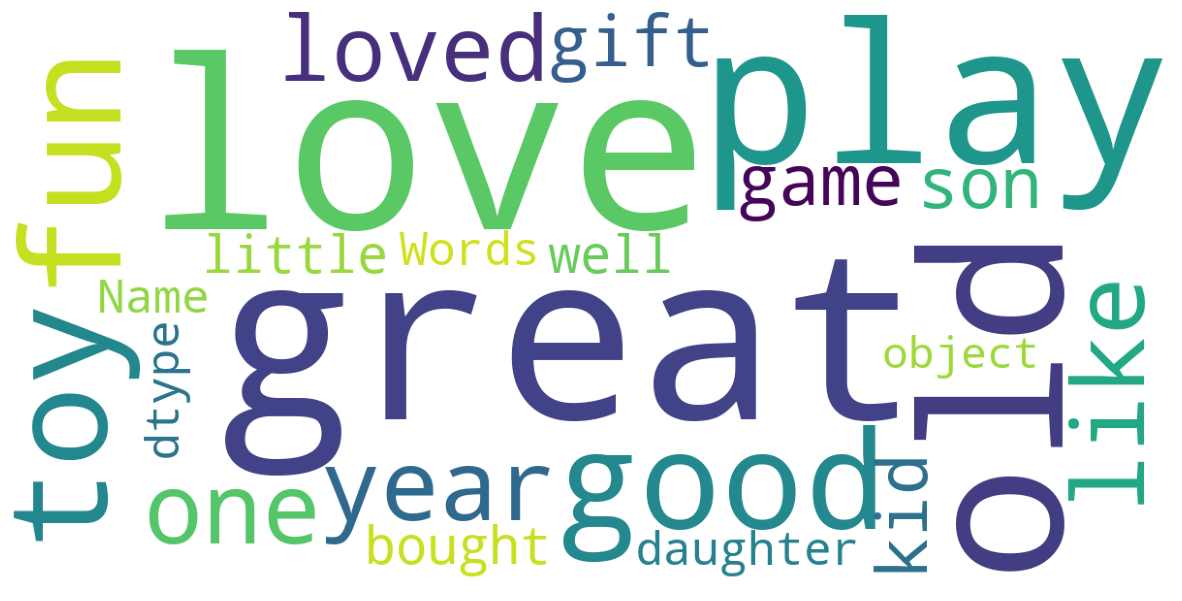

In [24]:
def wordclouds(corpus, color):
    stop_words = set(stopwords.words('english'))
    wordcloud = WordCloud(
        background_color=color,
        stopwords=stop_words,
        max_words=100,
        scale=3,
        
    )

    wordcloud = wordcloud.generate(corpus)
    fig = plt.figure(1, figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off')

    return plt.show()

wordcloud = frequencies.reset_index()
wordcloud = wordcloud['Words']
wordclouds(str(wordcloud), '#ffffff')



## WordTree

Se realiza un WordTree con la palabra más frecuente obtenida del conteo de palabras

  0%|          | 0/640429 [00:00<?, ?it/s]

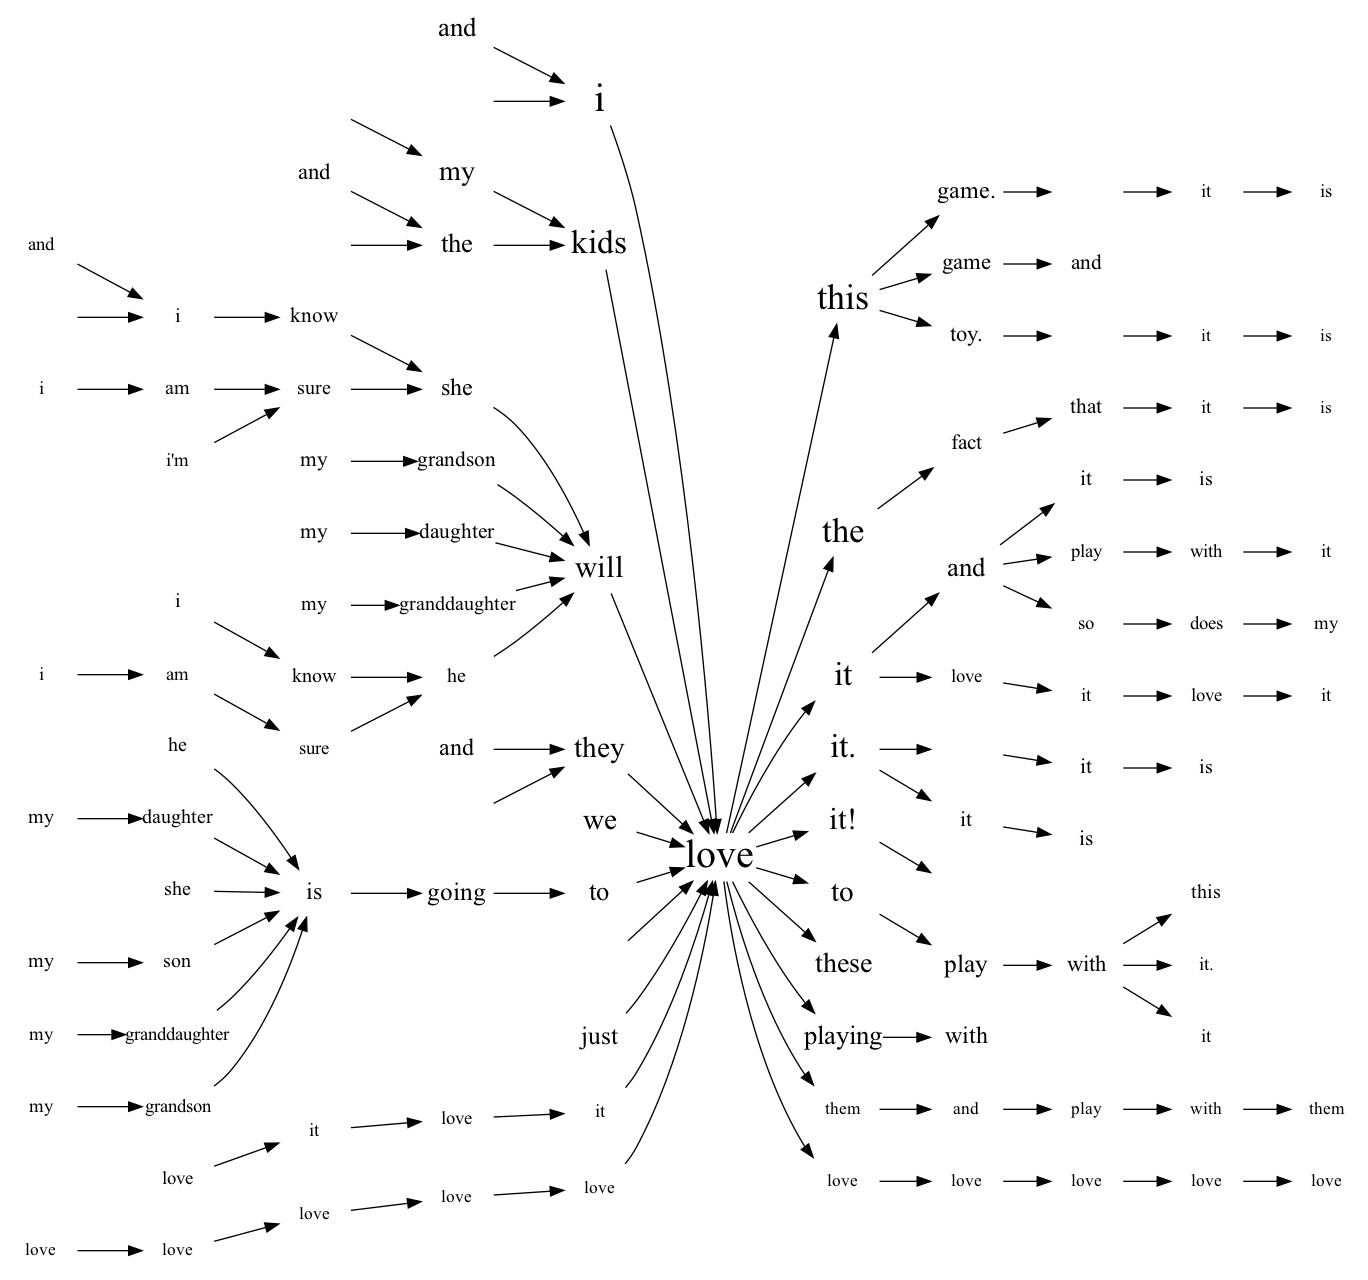

In [25]:
from PIL import Image

df_corpus_list = amazon['reviews'].tolist()
g = wordtree.search_and_draw(corpus=df_corpus_list, keyword='love', max_n=6)
g.render()
Image.open('love.gv.png')

## UMAP

Se establece una función para remover stopwords y se crea un dataset previo a llamar la función TfIdVectorizer

In [26]:
def remove_stopword(words):
    stop_words = set(stopwords.words('english'))
    stop_words.update([ 'would', 'really', "'s", "n't", 'www',
                    'amazon', 'com', 'gp', "'t", 'http', 'https'])
    return [w for w in words if w.lower() not in stop_words]

In [27]:

dataset = amazon['reviews'].tolist()
dataset = [remove_stopword(tokenize(word)) for word in dataset]
dataset = [' '.join(word) for word in dataset]
dataset = [w.lower() for w in dataset]
print(dataset[0:10])

['see directions use therefore make games unfortunately', 'great product thank son loved puzzles large pieces yet still challenging year old', 'glad get yr waiting ended', 'nephew niece loved highly recommended page puzzle back dr seuss blurbs puzzles look cheap', 'great coloring activity book young children arrived plenty time daughter birthday recommend', 'complex game takes learn play multiple people lot fun', 'wish flags depicted picture shows exactly get less looking', 'one first starting magic loved easy trick anyone brain', 'realize piece aluminum flimsy child get much use', 'great new looses memory quickly stored properly hard thing kids manage']


Se realiza la vectorización. Se muestra un dataframe al final para mostrar los resultados

In [28]:
vectorizer = TfidfVectorizer(use_idf=True)

tfidf = vectorizer.fit_transform(dataset)
df_tfidf = pd.DataFrame(
    tfidf[0].T.todense(), 
    index=vectorizer.get_feature_names_out(), 
    columns=['tf-idf']
    )

df_tfidf = df_tfidf.sort_values('tf-idf', ascending=False)
df_tfidf.head(25)

,tf-idf
therefore,0.504336
unfortunately,0.461131
directions,0.433363
games,0.323443
see,0.313334
make,0.283878
use,0.248637
plastk,0.000000
plastis,0.000000
plastiky,0.000000


In [29]:
clusters = KMeans(n_clusters=5, n_init='auto', verbose=1)
clusters.fit(tfidf)


Initialization complete
Iteration 0, inertia 1221850.297322114.
Iteration 1, inertia 626542.1704911717.
Iteration 2, inertia 625729.8084665783.
Iteration 3, inertia 625223.033350212.
Iteration 4, inertia 624855.3745783273.
Iteration 5, inertia 624655.0849573598.
Iteration 6, inertia 624382.3507292034.
Iteration 7, inertia 624109.6191951195.
Iteration 8, inertia 623996.7906409131.
Iteration 9, inertia 623919.283438867.
Iteration 10, inertia 623843.7228702452.
Iteration 11, inertia 623746.778327009.
Iteration 12, inertia 623644.313978327.
Iteration 13, inertia 623580.3790257946.
Iteration 14, inertia 623564.5832130252.
Iteration 15, inertia 623563.0874383695.
Iteration 16, inertia 623562.9488577521.
Iteration 17, inertia 623562.9238596204.
Iteration 18, inertia 623562.9170272797.
Iteration 19, inertia 623562.9147865702.
Iteration 20, inertia 623562.9142037843.
Iteration 21, inertia 623562.9140838041.
Iteration 22, inertia 623562.9139619339.
Converged at iteration 22: center shift 8.48549

KMeans(n_clusters=5, n_init='auto', verbose=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

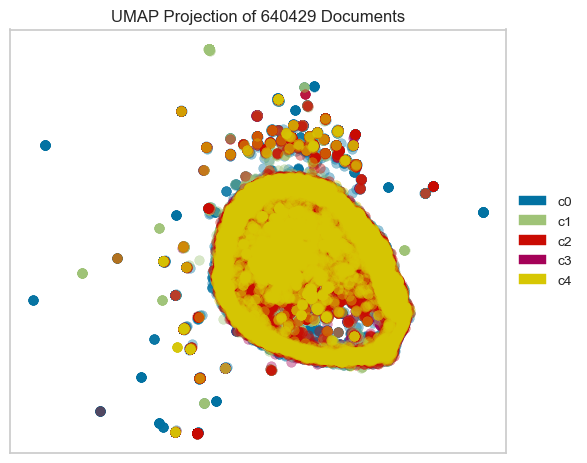

In [30]:
visualiser = umap(tfidf, ['c{}'.format(c) for c in clusters.labels_], alpha=0.4)

Como se observa en la gráfica, no muchas de los datos están muy alejados al agrupar los datos en cinco grupos. Esto quiere decir que muchos de los datos no se perciben mucho en el manifold de TF-IDF, por lo que la estructura de los datos los maneja muy bien el algoritmo de K-Means. Esto también puede servir para poder hacer predicciones de texto basado en estos agrupamientos.

## Sentiment Analysis

Se realizará el análisis de sentimiento de una lista reducida de reviews para poder hacer el análisis de forma más rápida. 

In [133]:
from sklearn.model_selection import train_test_split

amazon_sentiment, amazon_rest = train_test_split(amazon, train_size=10000, shuffle=True, stratify=amazon['overall'])
print('Analysis and rest sizes: ', amazon_sentiment.shape, amazon_rest.shape)


print('Total reviews: ', len(amazon_sentiment))

Analysis and rest sizes:  (10000, 6) (630429, 6)
Total reviews:  10000


In [45]:
pysent_analyzer = create_analyzer(lang='en', model_name='./bertweet-base-sentiment-analysis/')

def process(row):
    res=pysent_analyzer.predict(row['reviews'])
    return pd.Series({'sentiment': res.output, **res.probas})

amazon_with_sentiment = amazon_sentiment.join(amazon_sentiment.apply(process, axis=1))

loading configuration file ./bertweet-base-sentiment-analysis/config.json
Model config RobertaConfig {
  "_name_or_path": "./bertweet-base-sentiment-analysis/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.19.4",
  "type_vocab_size": 1,
  "use_

In [52]:
amazon_with_sentiment.head()

,index,reviews,overall,reviewTime,category,class,ID,sentiment,NEG,NEU,POS
0,382486,"great program: just got it today, and thus far...",5.0,2009-08-13,Toys_and_Games,1.0,382364.0,POS,0.001137,0.007202,0.991661
1,1394978,i bought this lego board game for my grandson....,5.0,2014-01-25,Toys_and_Games,1.0,1394667.0,POS,0.000653,0.030395,0.968952
2,440270,these are definitely necessary if you have a c...,5.0,2013-11-10,Toys_and_Games,1.0,440144.0,NEU,0.007519,0.790644,0.201837
3,1488488,"soft, cuddly, a favorite of my grandchild. gr...",5.0,2013-01-15,Toys_and_Games,1.0,1488152.0,POS,0.001163,0.006883,0.991954
4,445478,i chose the about items because that is what m...,5.0,2013-01-13,Toys_and_Games,1.0,445352.0,POS,0.001353,0.006037,0.992610


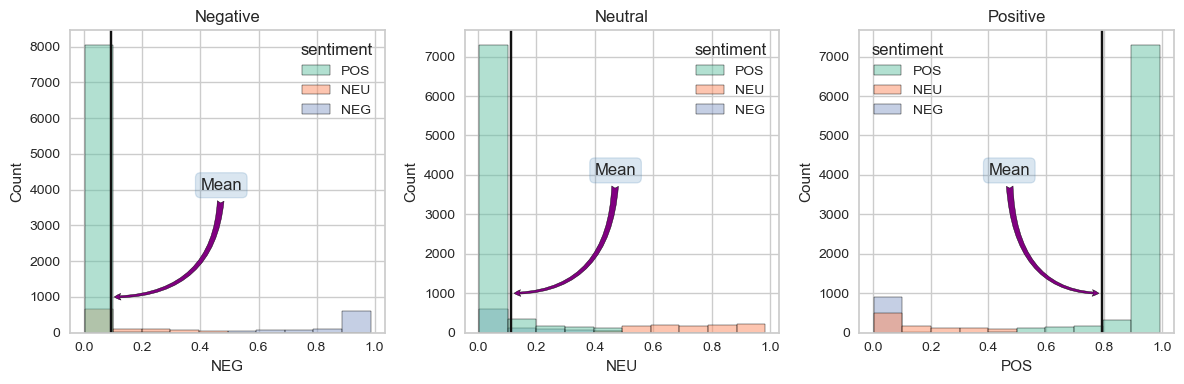

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
sns.histplot(data=amazon_with_sentiment, x='NEG', bins=10, hue='sentiment', palette='Set2', ax=axs[0])
sns.histplot(data=amazon_with_sentiment, x='NEU', bins=10, hue='sentiment', palette='Set2', ax=axs[1])
sns.histplot(data=amazon_with_sentiment, x='POS', bins=10, hue='sentiment', palette='Set2', ax=axs[2])
axs[0].set_title('Negative')
axs[0].axvline(amazon_with_sentiment['NEG'].mean(), color='k')
axs[0].annotate(text='Mean', xy=(amazon_with_sentiment['NEG'].mean(), 1000), xytext=(0.4, 4000), arrowprops=arrowprops, bbox=bbox)
axs[1].set_title('Neutral')
axs[1].annotate(text='Mean', xy=(amazon_with_sentiment['NEU'].mean(), 1000), xytext=(0.4, 4000), arrowprops=arrowprops, bbox=bbox)
axs[1].axvline(amazon_with_sentiment['NEU'].mean(), color='k')
axs[2].set_title('Positive')
axs[2].axvline(amazon_with_sentiment['POS'].mean(), color='k')
axs[2].annotate(text='Mean', xy=(amazon_with_sentiment['POS'].mean(), 1000), xytext=(0.4, 4000), arrowprops=arrowprops, bbox=bbox)
plt.tight_layout()
plt.show()

Como se observa en las gráficas superiores, de la muestra obtenida  (10.000 reviews), la mayoría de los comentarios en todas las categorías tienden a tener un resultado "positivo" conforme al análisis a través de pysentimiento. En la gráfica de 'Negative', se observa que la media es muy baja, aunque identifica correctamente algunos comentarios completamente negativos que se ven alrededor de los valores de 1. Mismo caso en la gráfica 'Neutral'. Para el caso de 'Positive', la mayoría de los comentarios están agrupados alrededor del valor de 1, con lo que se deduce que la mayoría de los comentarios en la muestra pertenecen a un sentimiento Positivo